In [1]:
import argparse
import random
import numpy as np
import pandas as pd
import pickle
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from pathlib import Path
from utils import *
from model.metric import evaluate, acc, LSR
from model.data import DAdataset
from model.net import LSTMClassifier
from torch.utils.tensorboard import SummaryWriter

In [2]:
data_dir = Path('dataset')
train_data_name = 'sw_train.txt'
valid_data_name = 'sw_val.txt'
test_data_name = 'sw_test.txt'
pretrained_embeddings_name = 'embeddings.pkl'
token2idx_name = 'word2idx.json'
label2idx_name = 'label2idx.json'
config_name = 'config.json'

In [3]:
args = {
    "seed": 2021,
    "epochs": 50,
    "n_batch": 1000,
    "max_len": 30,
    "lr": 0.001,
    "summary_step": 5000,
    "embedding_dim": 100,
    "hidden_size": 100,
    "save_dir": 'experiment'
}
args = argparse.Namespace(**args)
print(args)

Namespace(embedding_dim=100, epochs=50, hidden_size=100, lr=0.001, max_len=30, n_batch=1000, save_dir='experiment', seed=2021, summary_step=5000)


In [4]:
train_data = pd.read_csv(data_dir / train_data_name, header=None, sep='|', names=['speaker','utterance','tag'])
valid_data = pd.read_csv(data_dir / valid_data_name, header=None, sep='|', names=['speaker','utterance','tag'])
test_data = pd.read_csv(data_dir / test_data_name, header=None, sep='|', names=['speaker','utterance','tag'])

with open(data_dir / pretrained_embeddings_name, 'rb') as f:
    pretrained_embeddings = pickle.load(f)
    
with open(data_dir / token2idx_name, 'r') as f:
    token2idx = json.load(f)
    
with open(data_dir / label2idx_name, 'r') as f:
    label2idx = json.load(f)
    
with open(data_dir / config_name, 'r') as f:
    config = json.load(f)

In [5]:
idx2token = {i:t for t,i in token2idx.items()}
idx2label = {i:l for l,i in label2idx.items()}

In [6]:
x_train, y_train = train_data['utterance'], train_data['tag']
x_valid, y_valid = valid_data['utterance'], valid_data['tag']
x_test, y_test = test_data['utterance'], test_data['tag']

x_train = x_train.apply(sent2words)
x_valid = x_valid.apply(sent2words)
x_test = x_test.apply(sent2words)

In [7]:
x_train, x_train_seq_len = add_padding(x_train, args.max_len)
x_valid, x_valid_seq_len = add_padding(x_valid, args.max_len)
x_test, x_test_seq_len = add_padding(x_test, args.max_len)

In [8]:
x_train = list(convert_token_to_idx(x_train, token2idx))
x_valid = list(convert_token_to_idx(x_valid, token2idx))
x_test = list(convert_token_to_idx(x_test, token2idx))

In [9]:
y_train = convert_label_to_idx(y_train, label2idx)
y_valid = convert_label_to_idx(y_valid, label2idx)
y_test = convert_label_to_idx(y_test, label2idx)

In [10]:
tr_ds = DAdataset(x_train, y_train)
tr_dl = DataLoader(tr_ds, batch_size=args.n_batch, collate_fn=tr_ds.collate_fn, shuffle=True, drop_last=True)

val_ds = DAdataset(x_valid, y_valid)
val_dl = DataLoader(val_ds, batch_size=args.n_batch, collate_fn=val_ds.collate_fn, shuffle=True, drop_last=True)

test_ds = DAdataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=args.n_batch, collate_fn=test_ds.collate_fn, shuffle=True, drop_last=True)

In [28]:
learning_rate = args.lr
batch_size = args.n_batch
vocab_size = len(token2idx)
embedding_dim = args.embedding_dim
hidden_size = args.hidden_size
output_size = len(label2idx)

model = LSTMClassifier(batch_size, output_size, hidden_size, vocab_size, embedding_dim, torch.from_numpy(pretrained_embeddings))
# loss_fn = F.cross_entropy
loss_fn = LSR(epsilon=0.1, num_classes=output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    torch.cuda.empty_cache()

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)
writer = SummaryWriter(f'{args.save_dir}/runs')

In [29]:
best_val_loss = 1e+10
train_losses = []
valid_losses = []

for epoch in tqdm(range(args.epochs), desc='epochs'):
    tr_loss = 0
    tr_acc = 0
    model.train()
    
    for step, mb in tqdm(enumerate(tr_dl), desc='epochs', total=len(tr_dl)):
        x_mb, y_mb = map(lambda elm: elm.to(device), mb)
        
        optimizer.zero_grad()
        y_hat_mb = model(x_mb)
        loss = loss_fn(y_hat_mb, y_mb)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            mb_acc = acc(y_hat_mb, y_mb)
        
        clip_gradient(model, 1e-1)
        
        tr_loss += loss.item()
        tr_acc += mb_acc.item()
        
        if (epoch*len(tr_dl)+step) % args.summary_step == 0:
            val_loss = evaluate(model, val_dl, {'loss':loss_fn}, device)['loss']
            writer.add_scalars('loss', {'train': tr_loss / (step + 1), 'val': val_loss}, epoch*len(tr_dl) + step)
            tqdm.write('global_Step: {:3}, tr_loss: {:3f}, val_loss: {:3f}'.format(epoch* len(tr_dl) + step,
                                                                                       tr_loss / (step + 1),
                                                                                       val_loss))
            model.train()
    
    else:
        tr_loss  /= (step + 1)
        tr_acc /= (step + 1)
        train_losses.append(tr_loss)
        
        tr_sum = {'loss': tr_loss, 'acc': tr_acc}
        val_sum = evaluate(model, val_dl, {'loss': loss_fn, 'acc': acc}, device)
        tqdm.write('epoch : {}, tr_loss: {: 3f}, val_loss: '
                       '{:.3f}, tr_acc: {:.2%}, val_acc: {:.2%}'.format(epoch+1, tr_sum['loss'], val_sum['loss'],
                                                                        tr_sum['acc'], val_sum['acc']))
        
        val_loss = val_sum['loss']
        valid_losses.append(val_loss)
        is_best = val_loss < best_val_loss
        
        if is_best:
            state = {
                'epoch': epoch+1, 
                'model_state_dict': model.state_dict(), 
                'opt_state_dict': optimizer.state_dict()
            }
            summary = {'tr': tr_sum, 'val': val_sum}
            best_val_loss = val_loss

steps: 100%|██████████| 3/3 [00:00<00:00, 54.75it/s]


global_Step:   0, tr_loss: 1.221445, val_loss: 1.074232


steps: 100%|██████████| 3/3 [00:00<00:00, 51.72it/s]


epoch : 1, tr_loss:  0.757857, val_loss: 0.540, tr_acc: 50.59%, val_acc: 55.56%


steps: 100%|██████████| 3/3 [00:00<00:00, 58.82it/s]


epoch : 2, tr_loss:  0.572765, val_loss: 0.460, tr_acc: 63.12%, val_acc: 62.59%


steps: 100%|██████████| 3/3 [00:00<00:00, 49.06it/s]


epoch : 3, tr_loss:  0.503435, val_loss: 0.421, tr_acc: 67.99%, val_acc: 65.92%


steps: 100%|██████████| 3/3 [00:00<00:00, 58.82it/s]


epoch : 4, tr_loss:  0.465998, val_loss: 0.402, tr_acc: 70.73%, val_acc: 67.27%


steps: 100%|██████████| 3/3 [00:00<00:00, 50.43it/s]


epoch : 5, tr_loss:  0.444713, val_loss: 0.388, tr_acc: 72.29%, val_acc: 67.88%


steps: 100%|██████████| 3/3 [00:00<00:00, 57.69it/s]


epoch : 6, tr_loss:  0.430410, val_loss: 0.373, tr_acc: 73.22%, val_acc: 68.77%


steps: 100%|██████████| 3/3 [00:00<00:00, 55.56it/s]


epoch : 7, tr_loss:  0.421168, val_loss: 0.367, tr_acc: 73.70%, val_acc: 69.01%


steps: 100%|██████████| 3/3 [00:00<00:00, 52.63it/s]


epoch : 8, tr_loss:  0.414008, val_loss: 0.379, tr_acc: 74.11%, val_acc: 68.77%


steps: 100%|██████████| 3/3 [00:00<00:00, 58.86it/s]


epoch : 9, tr_loss:  0.408521, val_loss: 0.373, tr_acc: 74.48%, val_acc: 69.50%


steps: 100%|██████████| 3/3 [00:00<00:00, 54.55it/s]


epoch : 10, tr_loss:  0.403029, val_loss: 0.363, tr_acc: 74.93%, val_acc: 69.68%


steps: 100%|██████████| 3/3 [00:00<00:00, 54.55it/s]


epoch : 11, tr_loss:  0.397557, val_loss: 0.362, tr_acc: 75.27%, val_acc: 69.77%


steps: 100%|██████████| 3/3 [00:00<00:00, 50.85it/s]


epoch : 12, tr_loss:  0.393217, val_loss: 0.358, tr_acc: 75.50%, val_acc: 70.54%


steps: 100%|██████████| 3/3 [00:00<00:00, 60.00it/s]


epoch : 13, tr_loss:  0.388808, val_loss: 0.364, tr_acc: 75.78%, val_acc: 70.84%


steps: 100%|██████████| 3/3 [00:00<00:00, 54.55it/s]


epoch : 14, tr_loss:  0.384934, val_loss: 0.373, tr_acc: 76.02%, val_acc: 70.51%


steps: 100%|██████████| 3/3 [00:00<00:00, 54.55it/s]


epoch : 15, tr_loss:  0.380759, val_loss: 0.378, tr_acc: 76.19%, val_acc: 70.02%


steps: 100%|██████████| 3/3 [00:00<00:00, 58.82it/s]


epoch : 16, tr_loss:  0.376530, val_loss: 0.368, tr_acc: 76.50%, val_acc: 70.35%


steps: 100%|██████████| 3/3 [00:00<00:00, 52.63it/s]


epoch : 17, tr_loss:  0.372876, val_loss: 0.374, tr_acc: 76.72%, val_acc: 69.59%


steps: 100%|██████████| 3/3 [00:00<00:00, 54.54it/s]


epoch : 18, tr_loss:  0.369786, val_loss: 0.378, tr_acc: 76.89%, val_acc: 69.87%


steps: 100%|██████████| 3/3 [00:00<00:00, 55.56it/s]


epoch : 19, tr_loss:  0.365381, val_loss: 0.375, tr_acc: 77.19%, val_acc: 70.02%


steps: 100%|██████████| 3/3 [00:00<00:00, 56.60it/s]


epoch : 20, tr_loss:  0.361440, val_loss: 0.385, tr_acc: 77.36%, val_acc: 68.55%


steps: 100%|██████████| 3/3 [00:00<00:00, 58.82it/s]


epoch : 21, tr_loss:  0.358411, val_loss: 0.390, tr_acc: 77.53%, val_acc: 69.99%


steps: 100%|██████████| 3/3 [00:00<00:00, 58.82it/s]


epoch : 22, tr_loss:  0.353927, val_loss: 0.390, tr_acc: 77.85%, val_acc: 69.99%


steps: 100%|██████████| 3/3 [00:00<00:00, 57.69it/s]


epoch : 23, tr_loss:  0.350184, val_loss: 0.408, tr_acc: 77.97%, val_acc: 68.86%


steps: 100%|██████████| 3/3 [00:00<00:00, 52.63it/s]


epoch : 24, tr_loss:  0.346753, val_loss: 0.405, tr_acc: 78.27%, val_acc: 69.56%


steps: 100%|██████████| 3/3 [00:00<00:00, 54.55it/s]


epoch : 25, tr_loss:  0.342379, val_loss: 0.402, tr_acc: 78.50%, val_acc: 70.23%


steps: 100%|██████████| 3/3 [00:00<00:00, 56.60it/s]


epoch : 26, tr_loss:  0.338512, val_loss: 0.469, tr_acc: 78.80%, val_acc: 68.06%


steps: 100%|██████████| 3/3 [00:00<00:00, 58.82it/s]


global_Step: 5000, tr_loss: 0.331908, val_loss: 0.442792


steps: 100%|██████████| 3/3 [00:00<00:00, 56.60it/s]


epoch : 27, tr_loss:  0.336011, val_loss: 0.475, tr_acc: 78.88%, val_acc: 69.32%


steps: 100%|██████████| 3/3 [00:00<00:00, 56.60it/s]


epoch : 28, tr_loss:  0.332438, val_loss: 0.442, tr_acc: 79.06%, val_acc: 69.25%


steps: 100%|██████████| 3/3 [00:00<00:00, 47.62it/s]


epoch : 29, tr_loss:  0.329168, val_loss: 0.457, tr_acc: 79.25%, val_acc: 68.92%


steps: 100%|██████████| 3/3 [00:00<00:00, 57.69it/s]


epoch : 30, tr_loss:  0.325118, val_loss: 0.478, tr_acc: 79.57%, val_acc: 68.67%


steps: 100%|██████████| 3/3 [00:00<00:00, 53.57it/s]


epoch : 31, tr_loss:  0.321855, val_loss: 0.478, tr_acc: 79.78%, val_acc: 68.64%


steps: 100%|██████████| 3/3 [00:00<00:00, 50.00it/s]


epoch : 32, tr_loss:  0.318836, val_loss: 0.513, tr_acc: 79.91%, val_acc: 68.86%


steps: 100%|██████████| 3/3 [00:00<00:00, 55.56it/s]


epoch : 33, tr_loss:  0.315672, val_loss: 0.488, tr_acc: 80.08%, val_acc: 68.22%


steps: 100%|██████████| 3/3 [00:00<00:00, 53.39it/s]


epoch : 34, tr_loss:  0.313150, val_loss: 0.552, tr_acc: 80.24%, val_acc: 67.88%


steps: 100%|██████████| 3/3 [00:00<00:00, 54.54it/s]


epoch : 35, tr_loss:  0.311478, val_loss: 0.495, tr_acc: 80.32%, val_acc: 69.07%


steps: 100%|██████████| 3/3 [00:00<00:00, 52.63it/s]


epoch : 36, tr_loss:  0.307378, val_loss: 0.501, tr_acc: 80.61%, val_acc: 68.92%


steps: 100%|██████████| 3/3 [00:00<00:00, 58.82it/s]


epoch : 37, tr_loss:  0.304782, val_loss: 0.535, tr_acc: 80.80%, val_acc: 68.25%


steps: 100%|██████████| 3/3 [00:00<00:00, 55.56it/s]


epoch : 38, tr_loss:  0.302517, val_loss: 0.536, tr_acc: 80.94%, val_acc: 68.12%


steps: 100%|██████████| 3/3 [00:00<00:00, 52.63it/s]


epoch : 39, tr_loss:  0.299012, val_loss: 0.577, tr_acc: 81.18%, val_acc: 68.52%


steps: 100%|██████████| 3/3 [00:00<00:00, 53.57it/s]


epoch : 40, tr_loss:  0.296922, val_loss: 0.599, tr_acc: 81.28%, val_acc: 68.31%


steps: 100%|██████████| 3/3 [00:00<00:00, 14.49it/s]


epoch : 41, tr_loss:  0.294307, val_loss: 0.583, tr_acc: 81.43%, val_acc: 68.52%


steps: 100%|██████████| 3/3 [00:00<00:00, 56.60it/s]


epoch : 42, tr_loss:  0.291951, val_loss: 0.613, tr_acc: 81.63%, val_acc: 67.94%


steps: 100%|██████████| 3/3 [00:00<00:00, 57.69it/s]


epoch : 43, tr_loss:  0.290819, val_loss: 0.575, tr_acc: 81.63%, val_acc: 68.64%


steps: 100%|██████████| 3/3 [00:00<00:00, 50.00it/s]


epoch : 44, tr_loss:  0.287268, val_loss: 0.656, tr_acc: 81.87%, val_acc: 68.37%


steps: 100%|██████████| 3/3 [00:00<00:00, 61.23it/s]


epoch : 45, tr_loss:  0.286198, val_loss: 0.646, tr_acc: 81.91%, val_acc: 67.85%


steps: 100%|██████████| 3/3 [00:00<00:00, 58.82it/s]


epoch : 46, tr_loss:  0.283297, val_loss: 0.629, tr_acc: 82.13%, val_acc: 67.94%


steps: 100%|██████████| 3/3 [00:00<00:00, 60.00it/s]


epoch : 47, tr_loss:  0.281884, val_loss: 0.612, tr_acc: 82.19%, val_acc: 67.57%


steps: 100%|██████████| 3/3 [00:00<00:00, 57.69it/s]


epoch : 48, tr_loss:  0.279741, val_loss: 0.741, tr_acc: 82.37%, val_acc: 68.80%


steps: 100%|██████████| 3/3 [00:00<00:00, 58.83it/s]


epoch : 49, tr_loss:  0.278204, val_loss: 0.626, tr_acc: 82.46%, val_acc: 67.36%


steps: 100%|██████████| 3/3 [00:00<00:00, 55.55it/s]


epoch : 50, tr_loss:  0.276298, val_loss: 0.678, tr_acc: 82.56%, val_acc: 67.63%



In [13]:
summary

{'tr': {'loss': 0.3913178524623315, 'acc': 0.7564010769128799},
 'val': {'loss': 0.35276217499980134, 'acc': 0.7001833949228954}}

In [16]:
summary

{'tr': {'loss': 0.3909037207874159, 'acc': 0.7569010751321912},
 'val': {'loss': 0.3573245444041301, 'acc': 0.7059902572107198}}

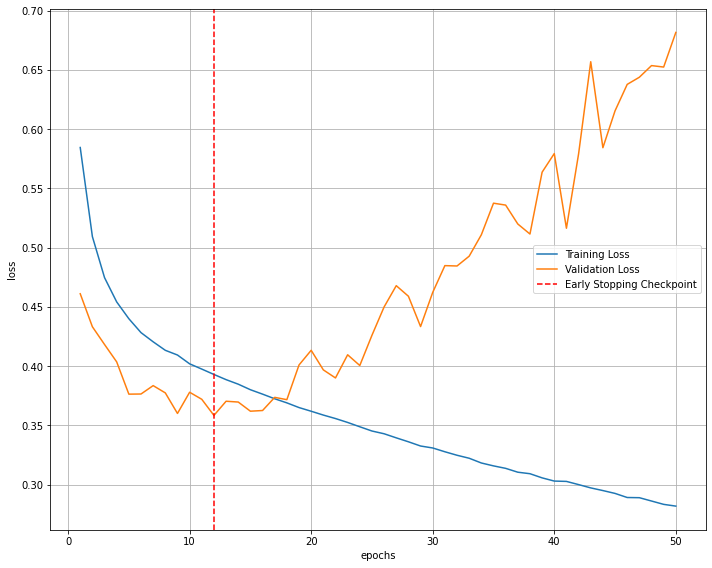

In [24]:
import matplotlib.pyplot as plt

# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1,len(valid_losses)+1), valid_losses, label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# fig.savefig('loss_plot.png', bbox_inches = 'tight')

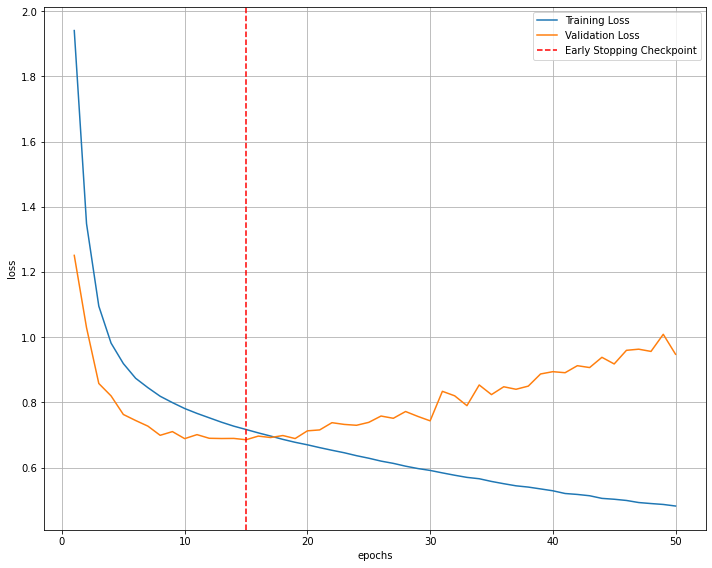

In [27]:
import matplotlib.pyplot as plt

# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1,len(valid_losses)+1), valid_losses, label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# fig.savefig('loss_plot.png', bbox_inches = 'tight')

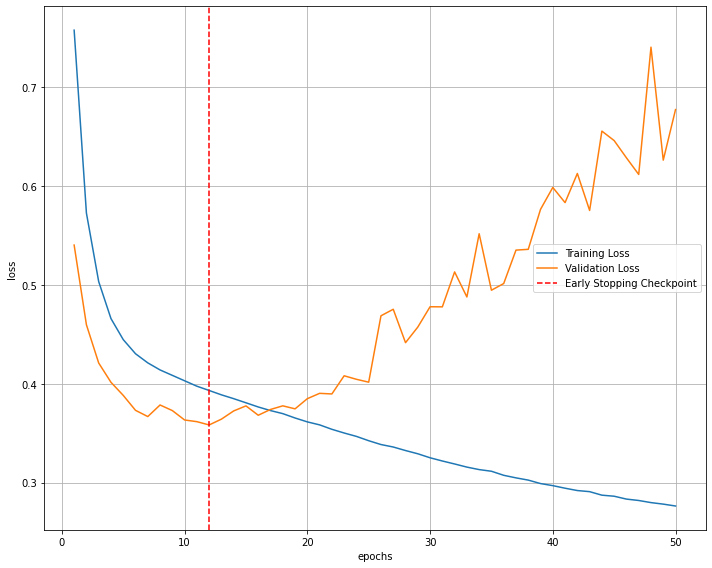

In [30]:
import matplotlib.pyplot as plt

# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1,len(valid_losses)+1), valid_losses, label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_losses.index(min(valid_losses))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# fig.savefig('loss_plot.png', bbox_inches = 'tight')

https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222
https://quokkas.tistory.com/entry/pytorch%EC%97%90%EC%84%9C-EarlyStop-%EC%9D%B4%EC%9A%A9%ED%95%98%EA%B8%B0